# Capstone Matrix Decomposition 


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Additional python packages
import os, urllib, io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
import scipy.misc
from ggplot import *
import time
from sklearn.manifold import TSNE
import sklearn
from functions import * # Our functions

init_notebook_mode(connected=True)

## Load images and meta data

In [19]:

images=[]
names=[]
for root, dirs, files in os.walk('final_dataset'):
    for name in files:
        mypath = os.path.join(root,name)
        img=Image.open(mypath, mode='r')
#         img = img.resize((128,128))
        arr = np.array(img).astype('uint8')
        images.append(arr)
        img.close()
        names.append(name.split('.')[0])

gene=[name.split('_')[0] for name in names]
days=[int(name.split('_')[1]) for name in names]
biofilm_number=[name.split('_')[2] for name in names]
dic={'label':names,'gene':gene,'days':days,'biofilm_number':biofilm_number}

df_all=pd.DataFrame.from_dict(dic)

## Lets look at some of the images

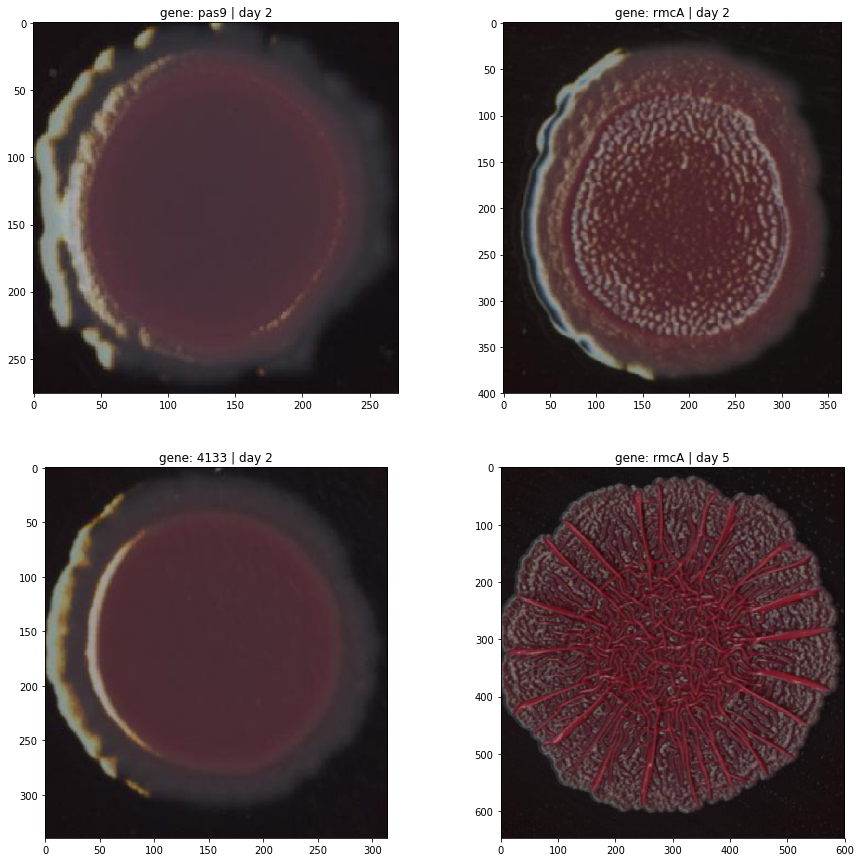

In [20]:
fig = plt.figure(figsize=(15,15))
n = 2

for i,s in enumerate(images):
    try:
        fig.add_subplot(n,n,i+1)
        plt.imshow(s)
        title = 'gene: %s | day %d' %(df_all['gene'][i],df_all['days'][i])
        plt.title(title)
    except:
        pass
plt.show()

### Process Images to find Wrinkles

In [21]:
def bf_size(image):
    a = image.max(axis=2)
    tmp = a > 30
    tmp_im = a * tmp
    return int(np.count_nonzero(tmp_im))
# def bf_size_vis(image):
#     a = image.max(axis=2)
#     tmp = a > 30
#     return a * tmp
def perc_wrinkled(img, biofilm_size):
    return round(np.count_nonzero(img)/biofilm_size,4)

In [22]:
import functions as fn

In [30]:
processed_images=[fn.threshold_image(img,threshold_val=100) for img in images]
bfsizes = [bf_size(img) for img in images]
df_all['bf_size'] = bfsizes
perc_wrink = [perc_wrinkled(img,bfsizes[i]) for i,img in enumerate(processed_images)]
df_all['perc_wrink'] = perc_wrink

### Plots of processed images

In [40]:
images[3].shape

(647, 600, 3)

In [62]:
l, cl = fn.get_classes(images[3], threshold_val=20, resize=600)

In [52]:
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(15,15))

n = 1

for i,s in enumerate(processed_images[3:3]):
    try:
        fig.add_subplot(n,n,i+1)
        plt.imshow(s, cmap='binary')
        title = '%s | %d | %f ' %(df_all['gene'][i],df_all['bf_size'][i],df_all['perc_wrink'][i])
        plt.title(title)
    except:
        pass
plt.show()

<Figure size 1080x1080 with 0 Axes>

<Figure size 720x720 with 0 Axes>

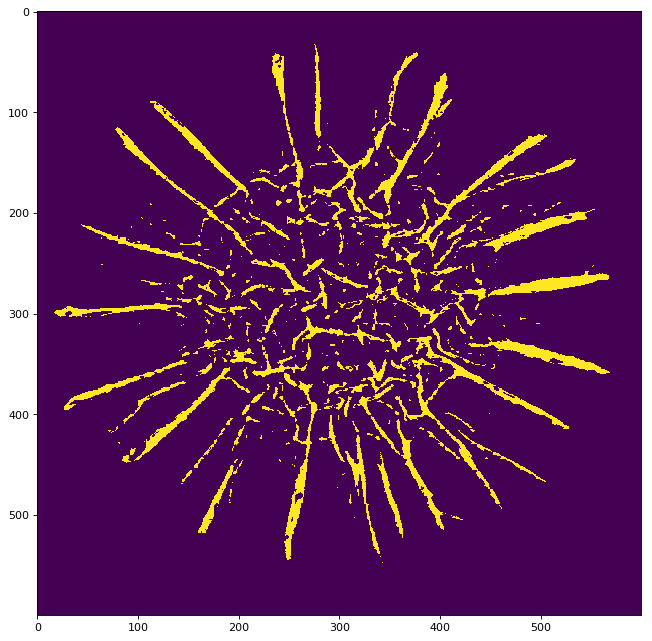

In [63]:
plt.figure(figsize=(10,10))
fn.plot_wrinkle_class(cl)

## Pre-process images for decomp


### We filter images that have wrinkle percent less than 2%. This mostly eliminates all biofilms that are 1 and 2 days old. 

In [73]:
tsne_data = []
tsne_info = pd.DataFrame(columns=df_all.columns)
for i,img in enumerate(images):
    if perc_wrink[i] > .02 and perc_wrink[i] < 1.0:
        tsne_data.append(img)
        tsne_info = tsne_info.append(df_all.iloc[[i]])

In [74]:
# X = [x[:,:,0] for x in X]
X = [x.flatten() for x in tsne_data]
X = np.asarray(X)

In [75]:
labels = tsne_info['gene'].unique()
tsne_info['y'] = [int(np.where(labels==s)[0]) for s in tsne_info['gene']]
y = np.array(tsne_info['y'])

In [124]:
X[3].shape

(49152,)

In [101]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

# lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h = X.shape
w = 1

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
n_features = X.shape[1]

# the label to predict is the id of the person
# y
target_names = labels
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 50

print("Extracting the top %d eigenvectors from %d biofilms"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))


print("Projecting the input data on the eigen orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting mutant type based on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

# def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
#     """Helper function to plot a gallery of portraits"""
#     plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
#     plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
#     for i in range(n_row * n_col):
#         plt.subplot(n_row, n_col, i + 1)
#         plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
#         plt.title(titles[i], size=12)
#         plt.xticks(())
#         plt.yticks(())


# plot the result of the prediction on a portion of the test set

# def title(y_pred, y_test, target_names, i):
#     pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
#     true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
#     return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# prediction_titles = [title(y_pred, y_test, target_names, i)
#                      for i in range(y_pred.shape[0])]

# plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

# eigenface_titles = ["eigenVec %d" % i for i in range(eigenfaces.shape[0])]
# plot_gallery(eigenfaces, eigenface_titles, h, w)

# plt.show()

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 583
n_features: 49152
n_classes: 7
Extracting the top 50 eigenvectors from 437 biofilms
done in 0.795s
Projecting the input data on the eigen orthonormal basis
done in 0.129s
Fitting the classifier to the training set
done in 4.448s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting mutant type based on the test set
done in 0.005s
              precision    recall  f1-score   support

        rmcA       0.84      0.95      0.89        22
    cco1cco2       1.00      0.70      0.82        10
        4133       0.88      0.74      0.80        19
          wt       0.93      0.78      0.85        18
        dipA       0.65      0.81      0.72        32
        pas9     

In [117]:
a = processed_images[140]
a = a.flatten()
a = a.reshape(1,-1)
# a = a.reshape(a.shape[0]*a.shape[1],1)

p_a = pca.transform(a)

ValueError: operands could not be broadcast together with shapes (1,16384) (49152,) 

In [119]:
import math

In [115]:
X_test[2].shape

(49152,)